## Init

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
import torch

if torch.cuda.is_available():
  dev = "cuda"
else:
  dev = "cpu"
device = torch.device(dev)

# device = torch.device('cpu')
print(device)

cuda


## SIM score

In [3]:
# %load par3/par3_align/similarity/sim_models.py
import torch
import torch.nn as nn
from torch.nn.modules.distance import CosineSimilarity
import numpy as np

class ParaModel(nn.Module):

    def __init__(self, args, vocab):
        super(ParaModel, self).__init__()

        self.args = args
        self.vocab = vocab
        self.gpu = args.gpu

        self.cosine = CosineSimilarity()

    def compute_mask(self, lengths):

        lengths = lengths.cpu()
        max_len = torch.max(lengths)
        range_row = torch.arange(0, max_len).long()[None, :].expand(lengths.size()[0], max_len)
        mask = lengths[:, None].expand_as(range_row)
        mask = range_row < mask
        mask = mask.float()
        if self.gpu >= 0:
            mask = mask.cuda()
        return mask

    def torchify_batch(self, batch):

        max_len = 0
        for i in batch:
            if len(i.embeddings) > max_len:
                max_len = len(i.embeddings)

        batch_len = len(batch)

        np_sents = np.zeros((batch_len, max_len), dtype='int32')
        np_lens = np.zeros((batch_len,), dtype='int32')

        for i, ex in enumerate(batch):
            np_sents[i, :len(ex.embeddings)] = ex.embeddings
            np_lens[i] = len(ex.embeddings)

        idxs, lengths, masks = torch.from_numpy(np_sents).long(), \
                               torch.from_numpy(np_lens).float().long(), \
                               self.compute_mask(torch.from_numpy(np_lens).long())

        if self.gpu >= 0:
            idxs = idxs.cuda()
            lengths = lengths.cuda()
            masks = masks.cuda()
    
        return idxs, lengths, masks

    def scoring_function(self, g_idxs1, g_mask1, g_lengths1, g_idxs2, g_mask2, g_lengths2):

        g1 = self.encode(g_idxs1, g_mask1, g_lengths1)
        g2 = self.encode(g_idxs2, g_mask2, g_lengths2)
        return self.cosine(g1, g2)

class WordAveraging(ParaModel):

    def __init__(self, args, vocab):
        super(WordAveraging, self).__init__(args, vocab)

        self.vocab = vocab
        self.embedding = nn.Embedding(len(self.vocab), self.args.dim)

        if args.gpu >= 0:
           self.cuda()

    def encode(self, idxs, mask, lengths):
        word_embs = self.embedding(idxs)
        word_embs = word_embs * mask[:, :, None]
        g = word_embs.sum(dim=1) / lengths[:, None].float()
        return g

In [4]:
# %load par3/par3_align/similarity/sim_utils.py
import io
import numpy as np
import torch

def get_wordmap(textfile):
    words={}
    We = []
    f = io.open(textfile, 'r', encoding='utf-8')
    lines = f.readlines()
    if len(lines[0].split()) == 2:
        lines.pop(0)
    ct = 0
    for (n,i) in enumerate(lines):
        word = i.split(' ', 1)[0]
        vec = i.split(' ', 1)[1].split(' ')
        j = 0
        v = []
        while j < len(vec):
            v.append(float(vec[j]))
            j += 1
        words[word] = ct
        ct += 1
        We.append(v)
    return words, np.array(We)

def get_minibatches_idx(n, minibatch_size, shuffle=False):
    idx_list = np.arange(n, dtype="int32")

    if shuffle:
        np.random.shuffle(idx_list)

    minibatches = []
    minibatch_start = 0
    for i in range(n // minibatch_size):
        minibatches.append(idx_list[minibatch_start:
                                    minibatch_start + minibatch_size])
        minibatch_start += minibatch_size

    if (minibatch_start != n):
        # Make a minibatch out of what is left
        minibatches.append(idx_list[minibatch_start:])

    return zip(range(len(minibatches)), minibatches)

def max_pool(x, lengths, gpu):
    out = torch.FloatTensor(x.size(0), x.size(2)).zero_()
    if gpu >= 0:
        out = out.cuda()
    for i in range(len(lengths)):
        out[i] = torch.max(x[i][0:lengths[i]], 0)[0]
    return out

def mean_pool(x, lengths, gpu):
    out = torch.FloatTensor(x.size(0), x.size(2)).zero_()
    if gpu >= 0:
        out = out.cuda()
    for i in range(len(lengths)):
        out[i] = torch.mean(x[i][0:lengths[i]], 0)
    return out

def lookup(words, w):
    w = w.lower()
    if w in words:
        return words[w]

class Example(object):

    def __init__(self, sentence):
        self.sentence = sentence.strip().lower()
        self.embeddings = []
        self.representation = None

    def populate_embeddings(self, words):
        sentence = self.sentence.lower()
        arr = sentence.split()
        for i in arr:
            emb = lookup(words, i)
            if emb:
                self.embeddings.append(emb)
        if len(self.embeddings) == 0:
            self.embeddings.append(words['UUUNKKK'])

In [5]:
# # %load par3/par3_align/similarity/test_sim.py
# import torch
# from nltk.tokenize import TreebankWordTokenizer
# import sentencepiece as spm

# tok = TreebankWordTokenizer()

# model = torch.load('/home/kkatsy/par3/par3_align/similarity/sim/sim.pt')
# state_dict = model['state_dict']
# vocab_words = model['vocab_words']
# args = model['args']
# # turn off gpu
# model = WordAveraging(args, vocab_words)
# model.load_state_dict(state_dict, strict=True)
# sp = spm.SentencePieceProcessor()
# sp.Load('/home/kkatsy/par3/par3_align/similarity/sim/sim.sp.30k.model')
# model.eval()

# def make_example(sentence, model):
#     sentence = sentence.lower()
#     sentence = " ".join(tok.tokenize(sentence))
#     sentence = sp.EncodeAsPieces(sentence)
#     wp1 = Example(" ".join(sentence))
#     wp1.populate_embeddings(model.vocab)
#     return wp1

# def find_similarity(s1, s2):
#     with torch.no_grad():
#         s1 = [make_example(x, model) for x in s1]
#         s2 = [make_example(x, model) for x in s2]
#         wx1, wl1, wm1 = model.torchify_batch(s1)
#         wx2, wl2, wm2 = model.torchify_batch(s2)
#         BATCH_SIZE = 512
#         all_scores = []
#         for i in range(0, len(wx1), BATCH_SIZE):
#             scores = model.scoring_function(wx1[i:i + BATCH_SIZE], wm1[i:i + BATCH_SIZE], wl1[i:i + BATCH_SIZE],
#                                             wx2[i:i + BATCH_SIZE], wm2[i:i + BATCH_SIZE], wl2[i:i + BATCH_SIZE])
#             all_scores.extend([x.item() for x in scores])
#         return all_scores

# def find_similarity_matrix(s1, s2):
#     with torch.no_grad():
#         s1 = [make_example(x, model) for x in s1]
#         s2 = [make_example(x, model) for x in s2]
#         wx1, wl1, wm1 = model.torchify_batch(s1)
#         wx2, wl2, wm2 = model.torchify_batch(s2)

#         BATCH_SIZE = 2000
#         vecs1 = []
#         vecs2 = []
#         for i in range(0, len(wx1), BATCH_SIZE):
#             curr_vecs1 = model.encode(idxs=wx1[i:i + BATCH_SIZE],
#                                       mask=wm1[i:i + BATCH_SIZE],
#                                       lengths=wl1[i:i + BATCH_SIZE])
#             vecs1.append(curr_vecs1)
#         for i in range(0, len(wx2), BATCH_SIZE):
#             curr_vecs2 = model.encode(idxs=wx2[i:i + BATCH_SIZE],
#                                       mask=wm2[i:i + BATCH_SIZE],
#                                       lengths=wl2[i:i + BATCH_SIZE])
#             vecs2.append(curr_vecs2)
#         vecs1 = torch.cat(vecs1)
#         vecs2 = torch.cat(vecs2)
#         dot_product = torch.matmul(vecs1, vecs2.t())

#         vecs1_norm = torch.norm(vecs1, dim=1, keepdim=True)
#         vecs2_norm = torch.norm(vecs2, dim=1, keepdim=True)
#         norm_product = torch.matmul(vecs1_norm, vecs2_norm.t())
#     return torch.div(dot_product, norm_product)

# def encode_text(s1):
#     with torch.no_grad():
#         s1 = [make_example(x, model) for x in s1]
#         wx1, wl1, wm1 = model.torchify_batch(s1)
#         vecs1 = model.encode(idxs=wx1, mask=wm1, lengths=wl1)
#         return vecs1


In [6]:
# tok = TreebankWordTokenizer()

# model = torch.load('/home/kkatsy/par3/par3_align/similarity/sim/sim.pt')
# state_dict = model['state_dict']
# vocab_words = model['vocab_words']
# args = model['args']
# # turn off gpu
# model = WordAveraging(args, vocab_words)
# model.load_state_dict(state_dict, strict=True)
# sp = spm.SentencePieceProcessor()
# sp.Load('/home/kkatsy/par3/par3_align/similarity/sim/sim.sp.30k.model')
# model.eval()

In [7]:
def get_score(refs, cands, metric='sim'):
    return find_similarity(refs,cands)

## Data Prep

In [8]:
import pickle

with open('aligned_paragraph_dataset.pickle', 'rb') as fp:
  aligned_paragraph_dataset = pickle.load(fp)

with open('source_paragraph_dataset.pickle', 'rb') as fp:
  source_paragraph_dataset = pickle.load(fp)

In [9]:
aligned_paragraph_dataset['NotesFromUnderground'][260:265]

[{'Katz': '"You\'re a scoundrel," the thought flashed through my mind, "if you laugh at that now.\'',
  'PV': '"What a scoundrel you are," raced through my head, "to laugh at that now!"',
  'Garnett': '"You are a scoundrel," a thought flashed through my mind, "if you laugh at this now."',
  'Hogarth': '"You cur! " I went on, in objurgation of Zvierkov.'},
 {'Katz': '"So what!" I cried in reply. "Everything is lost now, anyway!"',
  'PV': '"What of it!" I cried, answering myself. "All is lost now!"',
  'Garnett': '"No matter!" I cried, answering myself. "Now everything is lost!"',
  'Hogarth': '"What if you should get the laugh of me even now?" "No matter if he does," I cried the next moment, in answer to myself. " Hy now you have lost everything."'},
 {'Katz': "There was no sign of them, but it didn't matter. I knew where they were going.",
  'PV': 'Their trail was already cold; but no matter: I knew where they had gone.',
  'Garnett': 'There was no trace to be seen of them, but that m

In [10]:
source_paragraph_dataset['NotesFromUnderground'][260:265]

['«Подлец ты!— пронеслось в моей голове,— коли над этим теперь смеешься».',
 '—Пусть!— крикнул я, отвечая себе.— Теперь ведь уж все погибло!',
 'Их уж и след простыл; но все равно: я знал, куда они поехали.',
 'У крыльца стоял одинокий Ванька, ночник, в сермяге, весь запорошенный все еще валившимся мокрым и как будто теплым снегом. Было парно и душно. Маленькая лохматая, пегая лошаденка его была тоже вся запорошена и кашляла; я это очень помню. Я бросился в лубошные санки; но только было я занес ногу, чтоб сесть, воспоминание о том, как Симонов сейчас давал мне шесть рублей, так и подкосило меня, и я, как мешок, повалился в санки.',
 '—Нет! Надо много сделать, чтоб все это выкупить!— прокричал я,— но я выкуплю или в эту же ночь погибну на месте. Пошел!']

In [11]:
import itertools
from statistics import mean
from operator import itemgetter

def get_best_alignments(par_list, source_par_list, top_k_percent, num_k, drop_top, metric, min_len, max_len):

    # dict -> score:par_set
    # iter thru par_list, prune by length, get metric for set
    keep_index_list = []
    i2score = {}
    for i in range(len(par_list)):
        keep_index_list.append(i)
        par_set = par_list[i]

        max_par_len = len(max(par_set, key = len))
        min_par_len = len(min(par_set, key = len))
        source_len = len(source_par_list[i])

        if (min_par_len >= min_len) and (max_par_len) <= max_len and not all(x==par_set[0] for x in par_set) and (max_par_len <= 3*source_len) and (min_par_len*3 >= source_len):

            pairs = list(itertools.combinations(par_set, 2))
            refs, cands = [], []
            for s1, s2 in pairs:
                refs.append(s1)
                cands.append(s2)
                
            pair_scores = get_score(refs, cands, metric)

            average_score = mean(pair_scores)
            i2score[i] = average_score

    # get top k par sets
    num_pars = len(list(i2score))
    top_k = int(top_k_percent * num_pars)
    if top_k >= num_k:
        top_k_scores = sorted(i2score.items(), key=itemgetter(1), reverse=True)[int(num_pars*drop_top):int(num_pars*drop_top) + num_k]
    else:
        top_k_scores = sorted(i2score.items(), key=itemgetter(1), reverse=True)[int(num_pars*drop_top):int(num_pars*drop_top) + top_k]
    
    i2score = sorted(i2score.items(), key=itemgetter(1), reverse=True)
    return i2score, top_k_scores, keep_index_list

In [12]:
min_paragraph_len = 20
max_paragraph_len = 1000000000000
top_k_percent = 0.9
num_k = 10000
drop_top = 0.02

In [13]:
list(aligned_paragraph_dataset.keys())

['DeadSouls',
 'FathersAndSons',
 'PoorFolk',
 'Demons',
 'AnnaKarenina',
 'NotesFromUnderground',
 'TheBrothersKaramazov',
 'TheIdiot',
 'CrimeAndPunishment']

In [14]:
# # format: label->translator, x->source+translation
# # dict: key-> translator, value: list of {source:s, translation:t, index:i}
# translator_to_pars = {}
# translator_to_pars_holdout = {}

# # Holdout
# # NotesFromUnderground - Katz, PV, Garnett, Hogarth
# # PoorFolk - McDuff, Hogarth, Garnett
# # TheIdiot - Garnett, McDuff, PV
# # CrimeAndPunishment - Katz, McDuff, PV, Garnett
# holdout_books = ['TheIdiot', 'NotesFromUnderground']
# ignore_books = []
# translator_to_pars = {}
# translator_to_pars_holdout = {}

# # for each book in train:
# for book in sorted(list(aligned_paragraph_dataset.keys())):
#     # get par list of aligned sentences, best k alignments
#     book_par_list = [list(aligned_paragraph_dataset[book][p].values()) for p in range(len(aligned_paragraph_dataset[book]))]
#     source_par_list = source_paragraph_dataset[book]

#     if book in holdout_books:
#         i2score, top_k, keep_idx = get_best_alignments(book_par_list, source_par_list, 1.0, 5000, 0, 'sim', min_paragraph_len, max_paragraph_len)
#     elif book not in ignore_books:
#         i2score, top_k, keep_idx = get_best_alignments(book_par_list, source_par_list, top_k_percent, num_k, drop_top, 'sim', min_paragraph_len, max_paragraph_len)
#     else:
#         top_k = []

#     for i, sim in top_k:
#         par_trans_dict = aligned_paragraph_dataset[book][i]
#         par_source = source_paragraph_dataset[book][i]

#         for translator, t in par_trans_dict.items():
#             t = t.replace('\\\'', '\'')
#             datum_dict = {'source':par_source, 'translation': t, 'idx': i, 'book': book, 'sim': sim, 'translator': translator}

#             if translator not in translator_to_pars.keys():
#                 translator_to_pars[translator] = []
#                 translator_to_pars_holdout[translator] = []
                
#             if book in holdout_books:
#                 translator_to_pars_holdout[translator].append(datum_dict)
#                 # print('len par_list: ', len(book_par_list))
#                 # print('len top_k: ', len(top_k))
#             else:
#                 translator_to_pars[translator].append(datum_dict)

In [15]:
# BUILD TRAIN SET

# translators = ['Hogarth', 'PV', 'Katz', 'McDuff', 'Garnett']
# holdout_books = ['TheIdiot', 'NotesFromUnderground']

# translator_to_pars = {}

# for t in translators:
#     t_pars = []
#     for book in list(aligned_paragraph_dataset.keys()):
#         if book not in holdout_books:
#             if t in aligned_paragraph_dataset[book][0].keys():
#                 for par_dict in aligned_paragraph_dataset[book]:
#                     t_pars.append(par_dict[t])

#     print(t)
#     print(len(t_pars))

#     i2score, top_k, keep_idx = get_best_alignments(t_pars, top_k_percent, num_k, drop_top, 'sim', min_paragraph_len, max_paragraph_len)
    
#     # for i, sim in top_k:
#     print(len(top_k))
#     print()

# translator_to_pars_holdout = {}

In [16]:
# newlist = sorted(translator_to_pars['PV'], key=lambda d: d['sim'], reverse=True) 
# newlist[0:5]

In [17]:
# min_len = len(translator_to_pars['Hogarth'])
# print(min_len)
# for t in translator_to_pars.keys():
#     keep = sorted(translator_to_pars[t], key=lambda d: d['sim'], reverse=True)[:min_len]
#     translator_to_pars[t] = keep

In [18]:
# from random import sample

# min_len_h = len(translator_to_pars_holdout['Hogarth'])
# print(min_len_h)
# for t in translator_to_pars_holdout.keys():
#     keep = sample(translator_to_pars_holdout[t], min_len_h) 
#     translator_to_pars_holdout[t] = keep

In [19]:
# aligned_paragraph_dataset['Demons'][4748]

In [20]:
# abs_total = 0
# print('\nAll')
# for k in translator_to_pars_holdout.keys():
#     both = len(translator_to_pars_holdout[k]) + len(translator_to_pars[k])
#     print(k, both)
#     abs_total += both
# print('Total', abs_total)

# train_total = 0
# min_class = 100000000000
# print('\nTrain')
# for k in translator_to_pars.keys():
#     print(k, len(translator_to_pars[k]))
#     if len(translator_to_pars[k]) < min_class:
#         min_class = len(translator_to_pars[k])
    
# train_total = len(translator_to_pars.keys()) * min_class

# holdout_total = 0
# min_class_h = 100000000000
# print('\nHoldout')
# for k in translator_to_pars_holdout.keys():
#     print(k, len(translator_to_pars_holdout[k]))
#     if len(translator_to_pars_holdout[k]) < min_class_h:
#         min_class_h = len(translator_to_pars_holdout[k])

# holdout_total = len(translator_to_pars.keys()) * min_class_h

# print('Train total: ', min_class*5)
# print('Val/Test total: ', min_class_h*5)
# print()
# print('train % = ', train_total/(holdout_total+train_total))
# print('holdout % = ', holdout_total/(holdout_total+train_total))


In [40]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
class_keys = ["Garnett", "McDuff", "PV", "Katz", "Hogarth"]
le.fit(["Garnett", "McDuff", "PV", "Katz", "Hogarth"])
print(le.transform(["Garnett", "McDuff", "PV", "Katz", "Hogarth"]))

[0 3 4 2 1]


In [22]:
# data_list = []
# i = 0
# for tr in translator_to_pars.keys():
#     label = le.transform([tr])[0]
#     for d in translator_to_pars[tr]:
#         src, tgt = d['source'], d['translation']
#         concat = src + ' <SEP> ' + tgt
#         sent_dict = {'idx': d['idx'], 'book':d['book'], 'labels': label, 'concat': concat,  'translator': d['translator'], 'sim': d['sim'], 'src': src, 'tgt': tgt}
#         data_list.append(sent_dict)
#         i += 1


# data_list_holdout = []
# i = 0
# for tr in translator_to_pars_holdout.keys():
#     label = le.transform([tr])[0]
#     for d in translator_to_pars_holdout[tr]:
#         src, tgt = d['source'], d['translation']
#         concat = src + ' <SEP> ' + tgt
#         sent_dict = {'idx': d['idx'], 'book':d['book'], 'labels': label, 'concat': concat, 'translator': d['translator'], 'sim': d['sim'], 'src': src, 'tgt': tgt}
#         data_list_holdout.append(sent_dict)
#         i += 1
        
# print(data_list[:1])

In [23]:
# import pandas as pd

# df = pd.DataFrame(data_list)
# df_holdout = pd.DataFrame(data_list_holdout)
# pd.set_option('display.max_colwidth', 0)

In [24]:
# print(df.shape)
# print(df_holdout.shape)

In [25]:
# # {'idx': d['idx'], 'book':d['book'], 'labels': label, 'concat': concat, 'translator': d['translator'], 'sim': d['sim'], 'src': src, 'tgt': tgt}
# df_holdout_X = df_holdout[['idx','book', 'concat', 'translator', 'sim', 'src', 'tgt']]
# # df1.head()

In [26]:
# from sklearn.model_selection import train_test_split

# # train_texts = df['sentence'].values.tolist()
# # train_labels = df['labels'].values.tolist()
# # test_texts = df_holdout['concat'].values.tolist()
# # test_labels = df_holdout['labels'].values.tolist()

# # train_texts =  df['concat'].values.tolist()
# # train_labels = df['labels'].values.tolist()

# test_texts, val_texts, test_labels, val_labels = train_test_split(
#     df_holdout_X, df_holdout['labels'],
#     stratify = df_holdout['labels'], shuffle=True, test_size=0.5
# )

# train_df = df
# test_df = pd.concat([test_texts, test_labels], axis=1)
# val_df = pd.concat([val_texts, val_labels], axis=1)
# print('train size: ', train_df.shape)
# print('val size: ', val_df.shape)
# print('test size: ', test_df.shape)

# sentences = {}
# sentences['train'] = [{'label': row['labels'], 'text':row['concat']} for i, row in train_df.iterrows()]
# sentences['test'] = [{'label': row['labels'], 'text':row['concat']} for i, row in test_df.iterrows()]
# sentences['val'] = [{'label': row['labels'], 'text':row['concat']} for i, row in val_df.iterrows()]
# # for t, l in zip(train_texts, train_labels):
# #     datum = {'label': l, 'text': t}
# #     sentences['train'].append(datum)

# # for t, l in zip(val_texts, val_labels):
# #     datum = {'label': l, 'text': t}
# #     sentences['val'].append(datum)

# # for t, l in zip(test_texts, test_labels):
# #     datum = {'label': l, 'text': t}
# #     sentences['test'].append(datum)

# print(sentences['train'][770])


# print('train size: ', len(sentences['train']))
# print('val size: ', len(sentences['val']))
# print('test size: ', len(sentences['test']))

In [27]:
import pandas as pd 

train_df = pd.read_pickle("/home/kkatsy/litMT/experiment_dataset/aligned_train_df.pickle")  
test_df = pd.read_pickle("/home/kkatsy/litMT/experiment_dataset/experiment_test_df.pickle") 
val_df = pd.read_pickle("/home/kkatsy/litMT/experiment_dataset/experiment_val_df.pickle") 
print('train size: ', train_df.shape)
print('val size: ', val_df.shape)
print('test size: ', test_df.shape)

sentences = {}
sentences['train'] = [{'label': row['labels'], 'text':row['concat']} for i, row in train_df.iterrows()]
sentences['test'] = [{'label': row['labels'], 'text':row['concat']} for i, row in test_df.iterrows()]
sentences['val'] = [{'label': row['labels'], 'text':row['concat']} for i, row in val_df.iterrows()]


print('train size: ', len(sentences['train']))
print('val size: ', len(sentences['val']))
print('test size: ', len(sentences['test']))

train size:  (17735, 8)
val size:  (1175, 8)
test size:  (1175, 8)
train size:  17735
val size:  1175
test size:  1175


In [28]:
# with open('/home/kkatsy/litMT/classification_experiments_dataset.pickle', 'wb') as handle:
#     pickle.dump(sentences, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [29]:
# with open('/home/kkatsy/litMT/classification_experiments_dataset.pickle', 'wb') as handle:
#     a = pickle.load(sentences, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Train Model

In [30]:
if torch.cuda.is_available():
  dev = "cuda"
else:
  dev = "cpu"
device = torch.device(dev)

In [31]:
BERT_MODEL = "bert-base-multilingual-cased"

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased')

In [32]:
text1, text2 = sentences['train'][770]['text'].split(' <SEP> ')
tokenized1 = tokenizer([text1, text2], [text1, text2], padding='max_length', max_length=512, truncation='longest_first')
tokenized2 = tokenizer(text1, text2, padding='max_length', max_length=512, truncation='longest_first')


print(tokenized2.input_ids[256:])


[102, 10882, 62900, 19226, 10105, 19157, 10169, 43019, 57098, 11445, 117, 10261, 12174, 10472, 15217, 75349, 19113, 169, 16620, 14478, 23515, 117, 10146, 12277, 10108, 17333, 32782, 10336, 31031, 16460, 117, 10135, 10105, 13295, 10111, 10106, 10105, 21047, 17527, 10108, 41653, 10206, 67552, 51210, 14401, 119, 43019, 57098, 11445, 12149, 11898, 10226, 63646, 10111, 10169, 10226, 11250, 11170, 72333, 20006, 10708, 10105, 26234, 117, 24426, 31303, 10114, 10105, 14248, 95941, 10107, 10759, 110883, 10106, 48497, 83592, 10806, 10479, 171, 25497, 10114, 10957, 117, 64728, 39460, 10491, 10455, 28150, 119, 74857, 10230, 13448, 10111, 12153, 10114, 10105, 12541, 62026, 10604, 30518, 23203, 18800, 10108, 24742, 42948, 28524, 10479, 21031, 10741, 11155, 117, 10146, 14234, 30935, 117, 10261, 13446, 10114, 10105, 18121, 117, 15689, 10226, 32362, 10108, 12556, 41513, 10169, 169, 17684, 10108, 26228, 117, 10111, 12415, 26133, 10114, 10105, 37992, 11894, 79999, 10106, 29956, 14496, 13326, 117, 23455, 1

In [33]:
import datasets
import pandas as pd

train_dataset = datasets.Dataset.from_pandas(pd.DataFrame(data=sentences['train']))
val_dataset = datasets.Dataset.from_pandas(pd.DataFrame(data=sentences['val']))
test_dataset = datasets.Dataset.from_pandas(pd.DataFrame(data=sentences['test']))

In [34]:
def preprocess_function(datum):
    src, tgt = datum['text'].split(' <SEP> ')
    return tokenizer(src, tgt, padding='max_length', max_length=512, truncation='longest_first')

tokenized_train = train_dataset.map(preprocess_function)
tokenized_val = val_dataset.map(preprocess_function)
tokenized_test = test_dataset.map(preprocess_function)

Map:   0%|          | 0/17735 [00:00<?, ? examples/s]

Map:   0%|          | 0/1175 [00:00<?, ? examples/s]

Map:   0%|          | 0/1175 [00:00<?, ? examples/s]

In [35]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

2024-02-23 15:26:32.101179: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [36]:
import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [37]:
label_list = ["Garnett", "McDuff", "PV", "Katz", "Hogarth"]
id_list = le.transform(list(label_list))

id2label = {}
label2id = {}
for l, i in zip(label_list, id_list):
    id2label[i] = l
    label2id[l] = i

print(id2label)
print(label2id)

{0: 'Garnett', 3: 'McDuff', 4: 'PV', 2: 'Katz', 1: 'Hogarth'}
{'Garnett': 0, 'McDuff': 3, 'PV': 4, 'Katz': 2, 'Hogarth': 1}


In [38]:
fine_tune = True

In [41]:
from numpy import mean
from torch import nn
from torch.utils.data import DataLoader
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

# device (turn on GPU acceleration for faster execution)
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

if fine_tune:
    # model
    model = AutoModelForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels = len(class_keys))
    model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [42]:
lr = 2e-5
epochs = 5
batch_size = 8

In [43]:
import wandb

run = wandb.init(
        # Set the project where this run will be logged
        project="translator-classification-aligned",
        # Track hyperparameters and run metadata
        config={
            "learning_rate": lr,
            "epochs": epochs,
        },
    )

os.environ["WANDB_PROJECT"]="translator-classification-aligned"
os.environ["WANDB_NOTEBOOK_NAME"]="translator-classification-aligned"

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kkatsy. Use `wandb login --relogin` to force relogin


In [44]:
if fine_tune:
    training_args = TrainingArguments(
        output_dir="/home/kkatsy/pretrained",
        learning_rate=lr,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epochs,
        weight_decay=0.01,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=False,
        push_to_hub=False,
        report_to="wandb",
        logging_dir="/home/kkatsy/litMT/logs/",
        logging_strategy="epoch",
        logging_first_step=False

    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_val,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics
    )

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [45]:
import warnings
warnings.filterwarnings('ignore')

if fine_tune:
    trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.766400,1.578911,0.450213
2,0.433300,1.699028,0.490213
3,0.310500,2.055768,0.502979
4,0.225000,2.080844,0.582979
5,0.156200,2.391708,0.581277


Checkpoint destination directory /home/kkatsy/pretrained/checkpoint-2217 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory /home/kkatsy/pretrained/checkpoint-4434 already exists and is non-empty.Saving will proceed but saved results may be invalid.


In [46]:
if fine_tune:
    trainer.evaluate()

In [47]:
trainer.state.log_history

[{'loss': 0.7664,
  'learning_rate': 1.6000000000000003e-05,
  'epoch': 1.0,
  'step': 2217},
 {'eval_loss': 1.5789110660552979,
  'eval_accuracy': 0.4502127659574468,
  'eval_runtime': 14.9443,
  'eval_samples_per_second': 78.625,
  'eval_steps_per_second': 9.837,
  'epoch': 1.0,
  'step': 2217},
 {'loss': 0.4333, 'learning_rate': 1.2e-05, 'epoch': 2.0, 'step': 4434},
 {'eval_loss': 1.699028491973877,
  'eval_accuracy': 0.4902127659574468,
  'eval_runtime': 14.9458,
  'eval_samples_per_second': 78.617,
  'eval_steps_per_second': 9.836,
  'epoch': 2.0,
  'step': 4434},
 {'loss': 0.3105,
  'learning_rate': 8.000000000000001e-06,
  'epoch': 3.0,
  'step': 6651},
 {'eval_loss': 2.0557684898376465,
  'eval_accuracy': 0.5029787234042553,
  'eval_runtime': 14.983,
  'eval_samples_per_second': 78.422,
  'eval_steps_per_second': 9.811,
  'epoch': 3.0,
  'step': 6651},
 {'loss': 0.225,
  'learning_rate': 4.000000000000001e-06,
  'epoch': 4.0,
  'step': 8868},
 {'eval_loss': 2.0808444023132324,


In [50]:
eval_loss = []
eval_accuracy = []
train_loss = []

for d in trainer.state.log_history:
    # run.log(d)
    if 'eval_loss' in d.keys():
        eval_loss.append(d['eval_loss'])
        eval_accuracy.append(d['eval_accuracy'])
    elif 'loss' in d.keys():
        train_loss.append(d['loss'])
        
run_results = {'train_loss': train_loss, 'eval_loss':eval_loss, 'eval_accuracy': eval_accuracy}
run.log(run_results)

with open('/home/kkatsy/litMT/exp_logs/run_results.pickle', 'wb') as handle:
    pickle.dump(run_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [51]:
pd.DataFrame(trainer.state.log_history)

,loss,learning_rate,epoch,step,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,0.7664,0.000016,1.0,2217,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,1.0,2217,1.578911,0.450213,14.9443,78.625,9.837,NaN,NaN,NaN,NaN,NaN
2,0.4333,0.000012,2.0,4434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,2.0,4434,1.699028,0.490213,14.9458,78.617,9.836,NaN,NaN,NaN,NaN,NaN
4,0.3105,0.000008,3.0,6651,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,3.0,6651,2.055768,0.502979,14.9830,78.422,9.811,NaN,NaN,NaN,NaN,NaN
6,0.2250,0.000004,4.0,8868,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,4.0,8868,2.080844,0.582979,14.9983,78.342,9.801,NaN,NaN,NaN,NaN,NaN
8,0.1562,0.000000,5.0,11085,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,5.0,11085,2.391708,0.581277,15.0068,78.298,9.796,NaN,NaN,NaN,NaN,NaN


## Load Model

In [52]:
# import gc
# del model
# gc.collect()

# torch.cuda.empty_cache()

In [53]:
load_tuned = False

In [54]:
if load_tuned:
    model = AutoModelForSequenceClassification.from_pretrained("/trunk/kkatsy/aligned_20epochs_holdout")
    model.to(device)

In [55]:
if load_tuned:

    trainer = Trainer(
        model=model,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_val,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics
    )

## Evaluate

In [56]:
if load_tuned:
    trainer.evaluate()

In [57]:
predictions, labels, metrics = trainer.predict(tokenized_test, metric_key_prefix="predict")

In [58]:
preds = np.argmax(predictions, axis=-1)

pred_true = {'pred': preds, 'true': list(test_dataset['label'])}

with open('/home/kkatsy/litMT/exp_logs/pred_true.pickle', 'wb') as handle:
    pickle.dump(pred_true, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [59]:
translators = [id2label[l] for l in preds]

pred_count = {}
for i in label2id.keys():
    count = translators.count(i)
    pred_count[i] = count

pred_count

{'Garnett': 229, 'McDuff': 172, 'PV': 270, 'Katz': 288, 'Hogarth': 216}

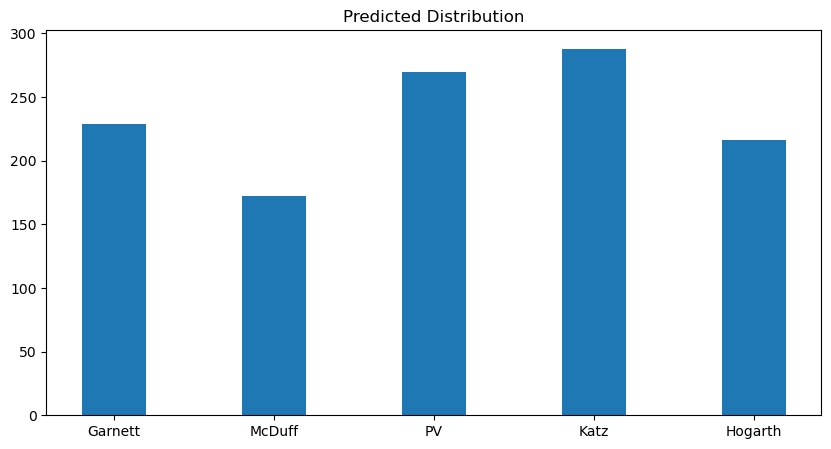

<Figure size 640x480 with 0 Axes>

In [60]:
import matplotlib.pyplot as plt


courses = list(pred_count.keys())
values = list(pred_count.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values, width = 0.4)
plt.title("Predicted Distribution")
plt.show()
plt.savefig('/home/kkatsy/litMT/exp_logs/Predicted Distribution.png')

In [61]:
true_count = {}
for i in id2label.keys():
    count = list(test_dataset['label']).count(i)
    true_count[id2label[i]] = count

true_count

{'Garnett': 235, 'McDuff': 235, 'PV': 235, 'Katz': 235, 'Hogarth': 235}

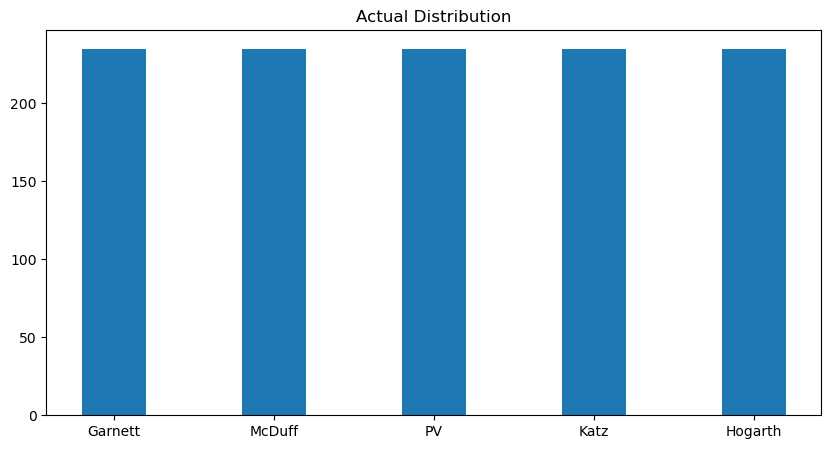

In [62]:
courses = list(true_count.keys())
values = list(true_count.values())
  
fig2 = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values, width = 0.4)
plt.title("Actual Distribution")
plt.show()

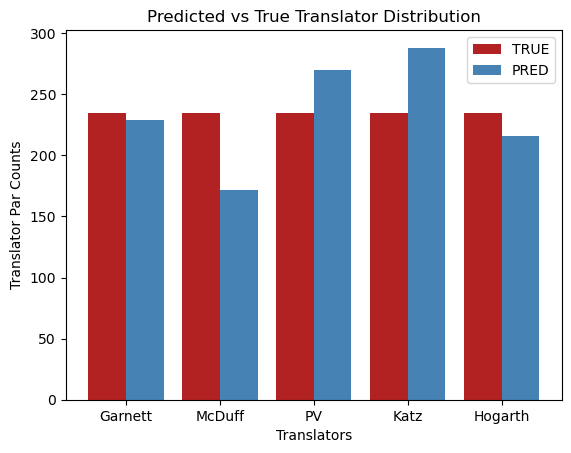

In [69]:
X = ['Group A','Group B','Group C','Group D'] 
Ygirls = [10,20,20,40] 
Zboys = [20,30,25,30] 
  
predicted = list(pred_count.values())
actual = list(true_count.values())
X_axis = np.arange(len(label_list))
  
plt.bar(X_axis - 0.2, actual, 0.4, label = 'TRUE', color='firebrick') 
plt.bar(X_axis + 0.2, predicted, 0.4, label = 'PRED', color='steelblue') 
  
plt.xticks(X_axis, label_list) 
plt.xlabel("Translators") 
plt.ylabel("Translator Par Counts") 
plt.title("Predicted vs True Translator Distribution") 
plt.legend() 
plt.show() 

Test Accuracy:  0.548936170212766


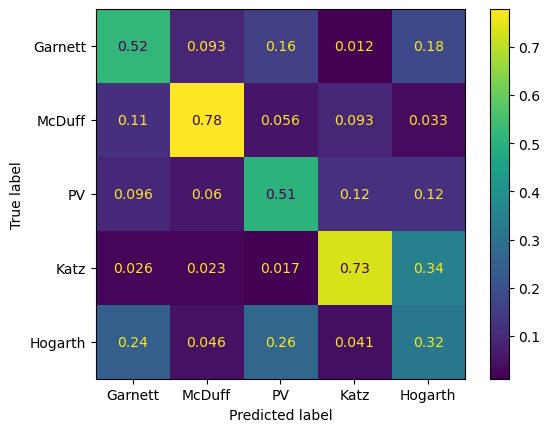

<Figure size 640x480 with 0 Axes>

In [63]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

acc = metrics.accuracy_score(labels, preds)
run.log({"Test accuracy":acc})
print('Test Accuracy: ', acc)

confusion_matrix = metrics.confusion_matrix(labels, preds, normalize='pred')
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels=label2id)
cm_display.plot()
plt.show()
plt.savefig('/home/kkatsy/litMT/exp_logs/Confusion Matrix')

In [64]:
# idiom lookup: search russian and english datasets for idioms
# english idiom dataset
wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Test accuracy,▁
eval/accuracy,▁▃▄███
eval/loss,▁▂▅▅██
eval/runtime,▄▄▇▇█▁
eval/samples_per_second,▅▅▂▂▁█
eval/steps_per_second,▅▅▂▁▁█
train/epoch,▁▁▃▃▅▅▆▆████
train/global_step,▁▁▃▃▅▅▆▆███████
train/learning_rate,█▆▅▃▁
train/loss,█▄▃▂▁
train/total_flos,▁
